In [ ]:
# !pip install transformers

## Intuitive Approach - Baseline

In [ ]:
# !python -m spacy download en_core_web_lg

In [ ]:
import spacy
import pandas as pd
import re
import spacy
import en_core_web_lg
nlp = en_core_web_lg.load()

In [ ]:
text = "A ratio showing how often people who see your ad or free product listing end up clicking it. \
 Clickthrough rate (CTR) can be used to gauge how well your keywords and ads, and free listings, are performing.\
 CTR is the number of clicks that your ad receives divided by the number of times your ad is shown: clicks ÷ impressions = CTR. \
 For example, if you had 5 clicks and 100 impressions, then your CTR would be 5%.Each of your ads, listings, and keywords have \
 their own CTRs that you can see listed in your account.A high CTR is a good indication that users find your ads and listings \
 helpful and relevant. CTR also contributes to your keyword's expected CTR, which is a component of Ad Rank. Note that a good CTR \
 is relative to what you're advertising and on which networks.You can use CTR to gauge which ads, listings, and keywords are successful \
 for you and which need to be improved. The more your keywords, ads, and listings relate to each other and to your business, the more likely \
 a user is to click on your ad or listing after searching on your keyword phrase."

In [ ]:
### Data pre-processing
'''
Below function is to remove stop words and focus on nouns/pronouns/verbs
'''
def filter_tokens_info(row):
  if ((row[7] == False ) & ((row[3] == 'NNP' ) |(row[3] == 'NN' ) |(row[3] == 'VBZ' ))):
    return row

    


In [ ]:
doc = nlp(text)
token_info = []
for token in doc:
  token_info.append([token.text, token.lemma_, token.pos_, token.tag_, token.dep_,token.shape_, token.is_alpha, token.is_stop])
token_info = pd.DataFrame(token_info,columns = ['text', 'lemma', 'pos_', 'tag', 'dep_','shape_', 'is_alpha', 'is_stop'] )

# token_info = token_info.apply(lambda row : filter_tokens_info(row),axis = 1)
# token_info.dropna(inplace = True)

In [ ]:
print('Proper Nouns cover the main entities covered')
print('\n Proper Noun \n',token_info[token_info['tag']=='NNP']['text'].unique())

print('\n \n Nouns cover the main sub-entities covered')
print('\nNoun \n',token_info[token_info['tag']=='NN']['text'].unique())

print('\n \nVerbs cover the aspects/actions on subentities or entities covered')
print('\n Verbs\n',token_info[token_info['tag']=='VBZ']['text'].unique())


Proper Nouns cover the main entities covered

 Proper Noun 
 ['Clickthrough' 'CTR' 'Ad' 'Rank']

 
 Nouns cover the main sub-entities covered

Noun 
 ['ratio' 'ad' 'product' 'listing' 'rate' 'number' 'example' 'account'
 'indication' 'keyword' 'component' 'business' 'user' 'phrase']

 
Verbs cover the aspects/actions on subentities or entities covered

 Verbs
 ['is' 'receives' 'contributes']


In [ ]:
Noun_chunks= []
for chunk in doc.noun_chunks:
  Noun_chunks.append([chunk.text, chunk.root.text, chunk.root.dep_,chunk.root.head.text])
Noun_chunks = pd.DataFrame(Noun_chunks,columns = ['TEXT',	'ROOT',	'DEP_','HEAD'])
print(Noun_chunks.DEP_.unique())
Noun_chunks[Noun_chunks['DEP_'].isin(['attr'])]

['ROOT' 'nsubj' 'dobj' 'conj' 'nsubjpass' 'appos' 'attr' 'pobj']


,TEXT,ROOT,DEP_,HEAD
12,the number,number,attr,is
34,a good indication,indication,attr,is
41,a component,component,attr,is


In [ ]:
NER_entity= []
for ent in doc.ents:
  NER_entity.append([ent.text, ent.start_char, ent.end_char, ent.label_])
NER_entity = pd.DataFrame(NER_entity,columns = ['TEXT',	'start_char',	'end_char','label_'])
print(NER_entity.TEXT.unique(),NER_entity.label_.unique())

['CTR' '5' '100' 'Ad Rank'] ['ORG' 'CARDINAL']


In [ ]:
##### Metric Areas covered

#### Now we can compute the similarity and dissimilarity accross Entities + Sub-entities + Actions
#### Considering 2 answers set (student (A) & reference (R)) [Use FastText + BERT embeddings for testing]
     ####- Find the token missing in the A but in  R by -> All the tokens in R which are highly dissimilar to all the tokens in A
     ####- Find the best matching pair tokens from A & R based on cossine similarity

### Get data for Software Design from Geeks for Geeks Links 

In [ ]:
!pip install requests
!pip install html5lib
!pip install bs4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
scrape_df = pd.DataFrame(columns=['Host','Topic_Domain','Url'])
scrape_df = scrape_df.append({'Host':'geeksforgeeks','Topic_Domain':'software design process','Url':"https://www.geeksforgeeks.org/software-engineering-software-design-process/?ref=gcse"},ignore_index= True)
scrape_df = scrape_df.append({'Host':'geeksforgeeks','Topic_Domain':'system design concepts','Url':"https://www.geeksforgeeks.org/5-common-system-design-concepts-for-interview-preparation/?ref=gcse"},ignore_index= True)
scrape_df = scrape_df.append({'Host':'geeksforgeeks','Topic_Domain':'basic system design concepts','Url':"https://www.geeksforgeeks.org/getting-started-with-system-design/?ref=lbp"},ignore_index= True)


In [ ]:
import requests
from bs4 import BeautifulSoup
import re

def get_headings(content,html_tags = ['h1','h2','h1','h3','h4','h5','h6','h7','strong']):
  headings = []
  for tag in html_tags:
    for row in content.findAll(tag):
      tag_content = match_html_tag(str(row),tag)
      if (tag_content != None) :
        sample_tag = tag_content[0][tag_content[0].find('>')+1:tag_content[0].find('</')]
        if (len(sample_tag.split(' ')) <= 4): # Filter tags as the topics can only be 4 words long
          headings.append(sample_tag)
  return headings

def match_html_tag(input,tag):
    pattern = re.compile(r"<"+str(tag)+"[a-zA-Z\s=\"]*>(.*?)</"+str(tag)+">", re.IGNORECASE)
    return pattern.match(input)

def get_some_entity_tags(content):
  tags = []
  for row in content.findAll('i'):
    tag_content = match_html_tag(str(row),str('i'))
    if (tag_content != None) :
      sample_tag = tag_content[0][tag_content[0].find('>')+1:tag_content[0].find('</')]
      if (len(sample_tag.split(' ')) <= 4): # Filter tags as the topics can only 4 words long
        tags.append(sample_tag)

  return tags

def parse_text(html):
  soup = BeautifulSoup(html, "html.parser")
  for data in soup(['style', 'script']):
      data.decompose()
  return ' '.join(soup.stripped_strings)

def get_page_text_content(content):
  text_content = ''
  for row in content.findAll('div',attrs={'class':'text'}):
    text_content =  text_content +'.' + parse_text(str(row))
  return text_content

In [ ]:
scrape_df.head()

,Host,Topic_Domain,Url
0,geeksforgeeks,software design process,https://www.geeksforgeeks.org/software-enginee...
1,geeksforgeeks,system design concepts,https://www.geeksforgeeks.org/5-common-system-...
2,geeksforgeeks,basic system design concepts,https://www.geeksforgeeks.org/getting-started-...


In [ ]:
scrape_df['tags'] = None
scrape_df['scraped_text'] = None

for index in range(0,scrape_df.shape[0]):
  URL = scrape_df.iloc[index,2]
  r = requests.get(URL)
  soup = BeautifulSoup(r.content,'html5lib')
  html_article = soup.find('article')
  tags = []
  text = get_page_text_content(html_article)
  scrape_df.iloc[index,4] = text
  
  tags.extend(get_headings(html_article))
  tags.extend(get_some_entity_tags(html_article))
  scrape_df.iloc[index,3] = str(tags)

  print('******Complete Scraping******',index)




******Complete Scraping****** 0
******Complete Scraping****** 1
******Complete Scraping****** 2


### Get Data from books

In [ ]:
!pip install PyPDF2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 199 kB 4.1 MB/s 


In [ ]:
import PyPDF2

def filter_line(line_content):
  line_content = re.sub("[^A-Za-z\s]"," ",line_content)
  line_content = re.sub(' +', ' ', line_content)
  if (line_content != '')&(len(line_content) > 20):
    return line_content

def generate_dataset_from_book(path = '/Corman.pdf'):
  book_dataset = pd.DataFrame(columns=['Page','Chapter','Text Extracted'])
  pdffileobj=open(path,'rb')
  pdfreader=PyPDF2.PdfFileReader(pdffileobj)
  chapter_topic = None
  for page_index in range(0,pdfreader.numPages):
    pageobj=pdfreader.getPage(page_index)
    text=pageobj.extractText()
    if text.split('\n')[0].find('Chapter') > 0:
      chapter_topic = text.split('\n')[0]
    text_lines = list(filter(lambda x:filter_line(x), text.split('\n')))
    for line_index in range(0,len(text_lines)):
      book_dataset = book_dataset.append({'Page':page_index,'Chapter':chapter_topic,'Text Extracted':text_lines[line_index]},ignore_index=True)
  return book_dataset


In [ ]:
corman_dataset = generate_dataset_from_book('/content/Corman.pdf')
corman_dataset.shape

(34832, 3)

In [ ]:
corman_dataset.to_csv('/content/Algo_Corman_extracted_txt.csv',index= False)

In [ ]:
corman_dataset.tail()

,Page,Chapter,Text Extracted
34827,1312,1140 Chapter 35 Approximation Algorithms,(elements of multiplicative group
34828,1312,1140 Chapter 35 Approximation Algorithms,(nonzero elements ofZ
34829,1312,1140 Chapter 35 Approximation Algorithms,"zero of a polynomial modulo a prime, 950 ex."
34830,1312,1140 Chapter 35 Approximation Algorithms,"0-1 integer programming, 1100 ex., 1125"
34831,1312,1140 Chapter 35 Approximation Algorithms,"0-1 knapsack problem, 425, 427 ex., 1137 pr.,"


### Latent Semantic Analysis

> Given text content (refer- Document) from different chapters of Algorithms(Coreman) trying to find the latent separability based on hidden topics



In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import re
import numpy as np
import pandas as pd
from scipy import linalg, spatial
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD
from sklearn.feature_extraction.text import (CountVectorizer, TfidfTransformer, TfidfVectorizer)
from sklearn.cluster import KMeans
from sklearn.utils.extmath import randomized_svd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


In [ ]:
# # np.unique(corman_dataset[~corman_dataset.Chapter.isna()]['Chapter'])

Chapter_Selected = {
    0: 'Dynamic Programming',
    1: 'Greedy Algorithms',
    2: 'Trees',
    3: 'Divide-and-Conquer',
    4: 'NP-Completeness'
}
corpus = []
for key in Chapter_Selected.keys():
  chapter = Chapter_Selected[key]
  chapter_text = '.'.join(list(corman_dataset[corman_dataset['Chapter'].str.contains(chapter)]['Text Extracted']))
  corpus.append(chapter_text)

print('Corpus Length',len(corpus))


Corpus Length 5


In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
filtered_document= []
filtered_text = []

for document in corpus:
    
    clean_document = " ".join(re.sub(r"[^A-Za-z \—]+", " ", document).split())
    
    document_tokens = word_tokenize(clean_document)

    for word in document_tokens:
        if word not in stop_words:
            filtered_document.append(word)

    filtered_text.append(' '.join(filtered_document))

In [ ]:
vectorizer = CountVectorizer()

counts_matrix = vectorizer.fit_transform(filtered_text)

feature_names = vectorizer.get_feature_names()

count_matrix_df = pd.DataFrame(counts_matrix.toarray(), columns=feature_names)
count_matrix_df.index = ['Document 1','Document 2','Document 3','Document 4','Document 5']

print("Word frequency matrix: \n", count_matrix_df)

Word frequency matrix: 
             aa  aand  aandbare  aanextensionofa  ab  abil  ability  \
Document 1   0     0         0                0   0     0        0   
Document 2   0     0         1                1   0     0        1   
Document 3   2     1         1                1   2     0        3   
Document 4   2     1         1                1   2     0        3   
Document 5   2     1         1                1   2     1       40   

            abilityproblem  abinary  able  ...  yields  yis  ylies  you  \
Document 1               0        0     1  ...       5    0      0   16   
Document 2               0        1     3  ...      16    0      0   19   
Document 3               0        1     3  ...      18    0      1   25   
Document 4               0        1     7  ...      26    0      1   36   
Document 5               1        1    49  ...      29    1      1   42   

            youare  young  your  yzpxmg  zdhb  zero  
Document 1       1      0     2       0     1    

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
vectorizer = TfidfVectorizer(stop_words=stop_words,max_features=10000, max_df = 0.5,
                                    use_idf = True,
                                    ngram_range=(1,3))

X = vectorizer.fit_transform(filtered_text)
print(X.shape)
print(feature_names)

num_clusters = 3

km = KMeans(n_clusters=num_clusters)
km.fit(X)
    
clusters = km.labels_.tolist()
print(clusters)

(5, 10000)
['aa', 'aand', 'aandbare', 'aanextensionofa', 'ab', 'abil', 'ability', 'abilityproblem', 'abinary', 'able', 'ableformula', 'ableif', 'ableswhosevaluesare', 'aboolean', 'abottleneck', 'above', 'absent', 'absolutely', 'absorb', 'absorbed', 'abstract', 'abstracts', 'abuse', 'ac', 'accept', 'acceptable', 'accepted', 'acceptedx', 'accepting', 'accepts', 'acceptsl', 'acceptsxby', 'access', 'accessed', 'accesses', 'accesseso', 'accessing', 'accomplish', 'accomplished', 'accomplishes', 'according', 'account', 'accounting', 'accu', 'accumulate', 'accumulated', 'accumulating', 'accurate', 'acerti', 'achicoulis', 'achieve', 'achieves', 'achieving', 'achoicethat', 'acircuit', 'acker', 'ackermann', 'acliquein', 'acme', 'acolorattributec', 'acommon', 'acomplexity', 'acon', 'aconcrete', 'acontainsjvj', 'across', 'act', 'acter', 'acters', 'actersa', 'acting', 'action', 'activ', 'activi', 'activities', 'activitiess', 'activity', 'activitya', 'acts', 'actu', 'actual', 'actually', 'actuallyn',

In [ ]:
U, Sigma, VT = randomized_svd(X, n_components=100, n_iter=100, random_state=122)

svd_model = TruncatedSVD(n_components=4, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)
    
print(U.shape)

for i, comp in enumerate(VT):
    terms_comp = zip(feature_names, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Cluster "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
    print(" ")


(5, 5)
Cluster 0: 
proves
decidel
keysd
dfu
sincexandyhave
createsasubproblems
creating
 
Cluster 1: 
decidel
dfu
sincexandyhave
vertexuto
leave
descends
converting
 
Cluster 2: 
aandbare
aand
aa
decidel
dfu
sincexandyhave
vertexuto
 
Cluster 3: 
aanextensionofa
aand
aa
decidel
dfu
sincexandyhave
vertexuto
 
Cluster 4: 
aandbare
aanextensionofa
proves
keysd
createsasubproblems
creating
recognition
 


In [ ]:
# use VT for document representation in topic space for similarity identification

### Topic Modeling : LDA Unsupervised

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

In [ ]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0] for word in count_vectorizer.inverse_transform(word_vectors)]#.encode('ascii').decode('utf-8')

    return (words, word_values[0,:n_top_words].tolist()[0])


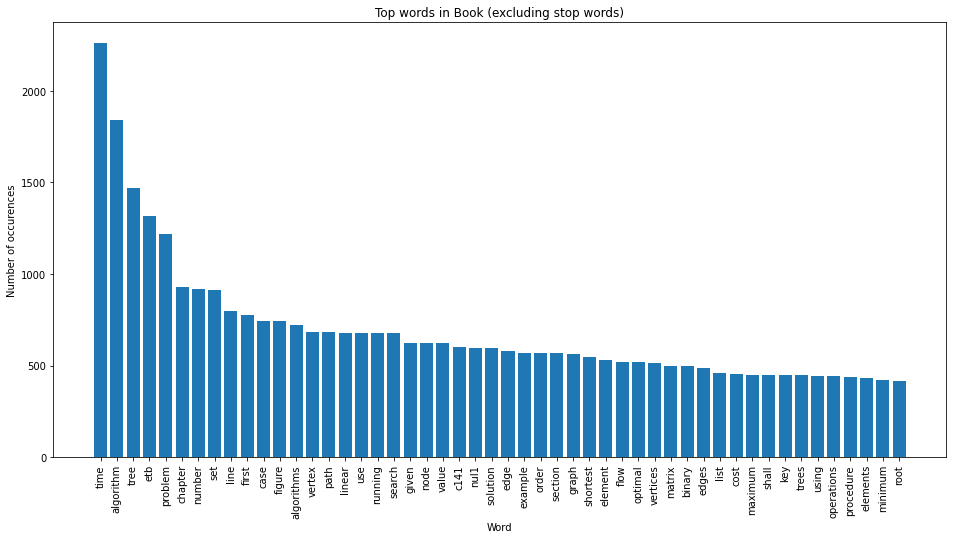

In [ ]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=50,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=corman_dataset['Text Extracted'])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in Book (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [ ]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = corman_dataset['Text Extracted'].sample(n=10000, random_state=0).values
print('Headline before vectorization: {}'.format(small_text_sample[123]))
small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)
print('Headline after vectorization: \n{}'.format(small_document_term_matrix[123]))

Headline before vectorization: /is maximum over all components other
Headline after vectorization: 
  (0, 2905)	1
  (0, 6823)	1


In [ ]:
n_topics = 10

In [ ]:
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

In [ ]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [ ]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [ ]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word)#.encode('ascii').decode('utf-8')
        top_words.append(" ".join(topic_words))         
    return top_words

In [ ]:
top_n_words_lsa = get_top_n_words(10, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  time running polynomial algorithm sort case constant bound worst takes
Topic 2:  etb edge vertex path 2e vertices etb2v edges ﬂow weight
Topic 3:  tree node binary key black figure minimum root trees search
Topic 4:  algorithm efﬁcient section multithreaded problem greedy computing compute dijkstra approximation
Topic 5:  problem solution given ﬂow np maximum linear optimal example suppose
Topic 6:  chapter algorithms number use section shall linear 31 analysis operations
Topic 7:  line c141 case value nul1 element figure list cost vertices
Topic 8:  path shortest graph vertex ﬁrst paths weight simple directed vertices
Topic 9:  ﬁrst search optimal form depth trees binary linear slack program
Topic 10:  set function disjoint dynamic list linear object independent operations data


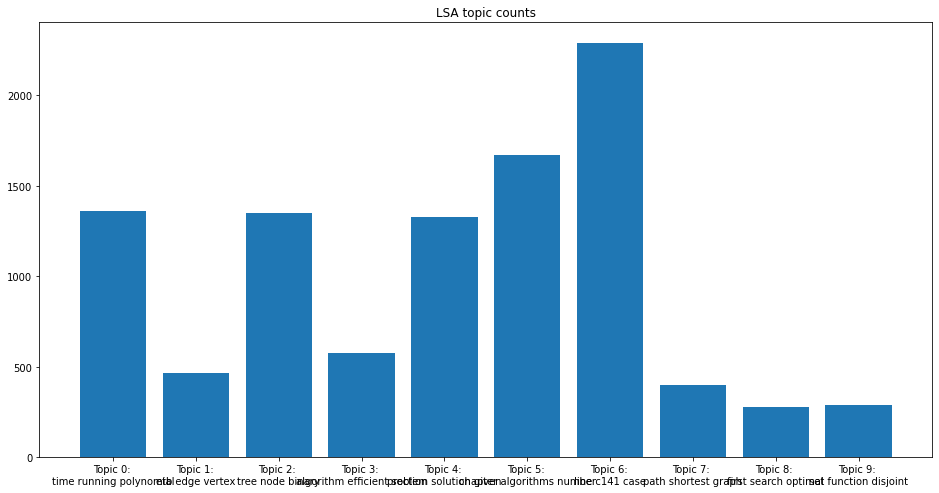

In [ ]:
top_3_words = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('');
ax.set_title('LSA topic counts');
plt.show()

In [ ]:
# tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
#                         n_iter=250, verbose=1, random_state=0, angle=0.75)
# tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

#### LDA

In [ ]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

In [ ]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [ ]:
top_n_words_lda = get_top_n_words(10, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  time search tree ﬁrst case binary order worst cost number
Topic 2:  chapter algorithms np matrix problem operations figure sort random operation
Topic 3:  line algorithm number divide recursive conquer algorithms matrix ex edges
Topic 4:  optimal solution tree black left right red ﬁnd child problem
Topic 5:  shortest path linear vertices programming paths edge use table algorithm
Topic 6:  ﬂow points notation pr length times given maximum asymptotic etb
Topic 7:  time etb algorithm problem running section polynomial lines figure theorem
Topic 8:  c141 data number value node algorithm structure trees array time
Topic 9:  set heap elements key probability 29 linear case program linked
Topic 10:  tree graph vertex nul1 element minimum directed c141 spanning node
